## Import libraries

In [268]:
import sys
import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

In [269]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [270]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Load data

In [271]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [272]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "ROB535_group_project/GTSRB"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Meta.csv', 'Test.csv', 'Train.csv', 'Meta', 'Test', 'Train', 'meta_data.pkl', 'train_data.pkl', 'test_data.pkl']


In [273]:
# To save time, just take 10% of train and test. In final run, change this to 1.0
fraction = 0.1

In [274]:
import cv2
import numpy as np
from tqdm import tqdm

def img_preprocess(df, path):
    X = []
    total_images = len(df['Path'])

    with tqdm(total=total_images, desc="Loading images", unit="image") as pbar:
        for img_path in df['Path']:
            img = cv2.imread(path + '/' + str(img_path))
            if img is None:
                print(f"Failed to load image: {img_path}")
                pbar.update(1)
                continue
            img = cv2.resize(img, (30, 30))
            # img = img / 255.0
            X.append(img)
            pbar.update(1)

    X = np.array(X)
    return X


## Meta

In [275]:
meta_csv_path = os.path.join(GOOGLE_DRIVE_PATH, "Meta.csv")
df1 = pd.read_csv(meta_csv_path, delimiter=',', nrows = None)
df1.dataframeName = 'Meta.csv'
nRow, nCol = df1.shape
print(f'Meta: {nRow} rows and {nCol} columns')

Meta: 43 rows and 5 columns


In [276]:
df1.head(5)

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [277]:
# meta_data = []

# meta_images = img_preprocess(df1, GOOGLE_DRIVE_PATH)

# for i, row in tqdm(df1.iterrows(), total=len(df1), desc="Processing meta data", unit="row"):
#     # Get the image from the preprocessed images
#     img = meta_images[i]

#     # Extract metadata
#     class_id = row['ClassId']
#     shape_id = row['ShapeId']
#     color_id = row['ColorId']
#     sign_id = row['SignId']

#     # Append to meta_data
#     meta_data.append({
#         "image": img,  # Store as NumPy array
#         "class_id": class_id,
#         "shape_id": shape_id,
#         "color_id": color_id,
#         "sign_id": sign_id
#     })

file_path1 = os.path.join(GOOGLE_DRIVE_PATH, "meta_data.pkl")
with open(file_path1, "rb") as f:
    meta_data = pickle.load(f)

## Train

In [278]:
train_csv_path = os.path.join(GOOGLE_DRIVE_PATH, "Train.csv")
df2 = pd.read_csv(train_csv_path, delimiter=',', nrows = None)
df2.dataframeName = 'Train.csv'

df2_sampled = df2.groupby('ClassId', group_keys=False).apply(lambda x: x.iloc[:int(len(x) * fraction)])
df2_sampled = df2_sampled.reset_index(drop=True)
nRow, nCol = df2_sampled.shape
print(f'Entire Train: {nRow} rows and {nCol} columns')

Entire Train: 3920 rows and 8 columns


<ipython-input-278-4d7fc9b2212f>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2_sampled = df2.groupby('ClassId', group_keys=False).apply(lambda x: x.iloc[:int(len(x) * fraction)])


In [279]:
df2_sampled.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,29,30,5,6,24,25,0,Train/0/00000_00000_00000.png
1,30,30,5,5,25,25,0,Train/0/00000_00000_00001.png
2,30,30,5,5,25,25,0,Train/0/00000_00000_00002.png
3,31,31,5,5,26,26,0,Train/0/00000_00000_00003.png
4,30,32,5,6,25,26,0,Train/0/00000_00000_00004.png


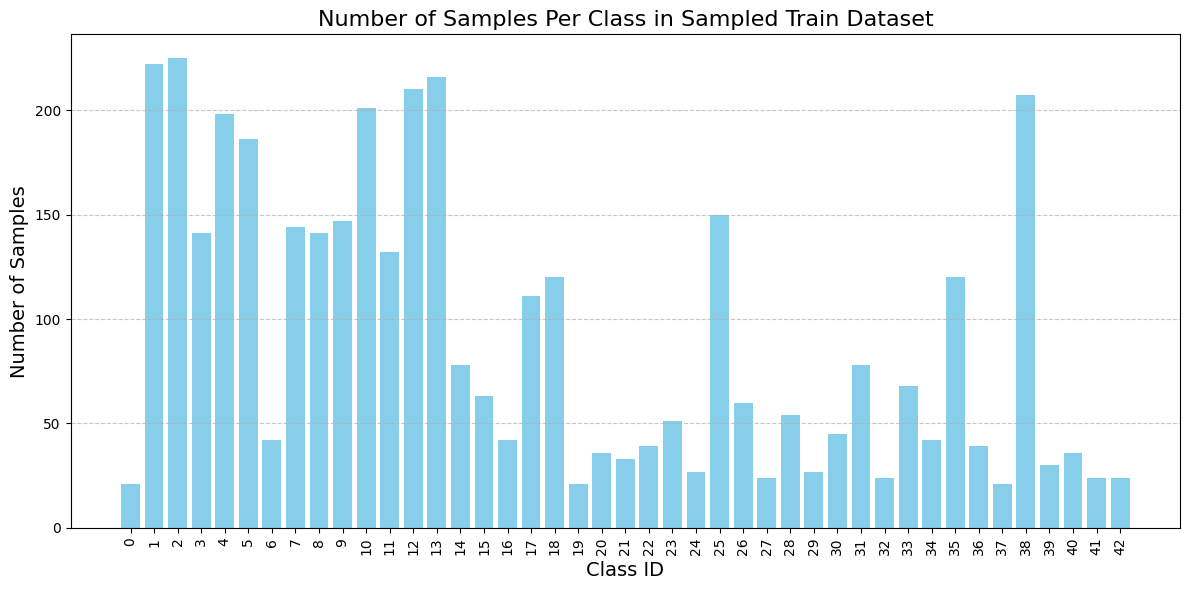

In [280]:
class_counts = df2_sampled['ClassId'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Class ID', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Number of Samples Per Class in Sampled Train Dataset', fontsize=16)
plt.xticks(class_counts.index, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [281]:
# train_data = []

# train_images = img_preprocess(df2_sampled, GOOGLE_DRIVE_PATH)

# for i, row in tqdm(df2_sampled.iterrows(), total=len(df2_sampled), desc="Processing train data", unit="row"):
#     img = train_images[i]

#     boxes = np.array([[row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']]], dtype=np.float32)
#     label = row['ClassId']

#     train_data.append({
#         "image": img,      # Preprocessed image (NumPy array)
#         "boxes": boxes,    # Bounding box (NumPy array)
#         "label": label     # Class ID
#     })


file_path2 = os.path.join(GOOGLE_DRIVE_PATH, "train_data.pkl")
with open(file_path2, "rb") as f:
    train_data = pickle.load(f)

## Test

In [282]:
test_csv_path = os.path.join(GOOGLE_DRIVE_PATH, "Test.csv")
df3 = pd.read_csv(test_csv_path, delimiter=',', nrows = None)
df3.dataframeName = 'Test.csv'

test_sample_size = int(len(df3) * fraction)
df3_sampled = df3.iloc[:test_sample_size].reset_index(drop=True)
nRow, nCol = df3_sampled.shape
print(f'Test: {nRow} rows and {nCol} columns')

Test: 1263 rows and 8 columns


In [283]:
df3_sampled.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


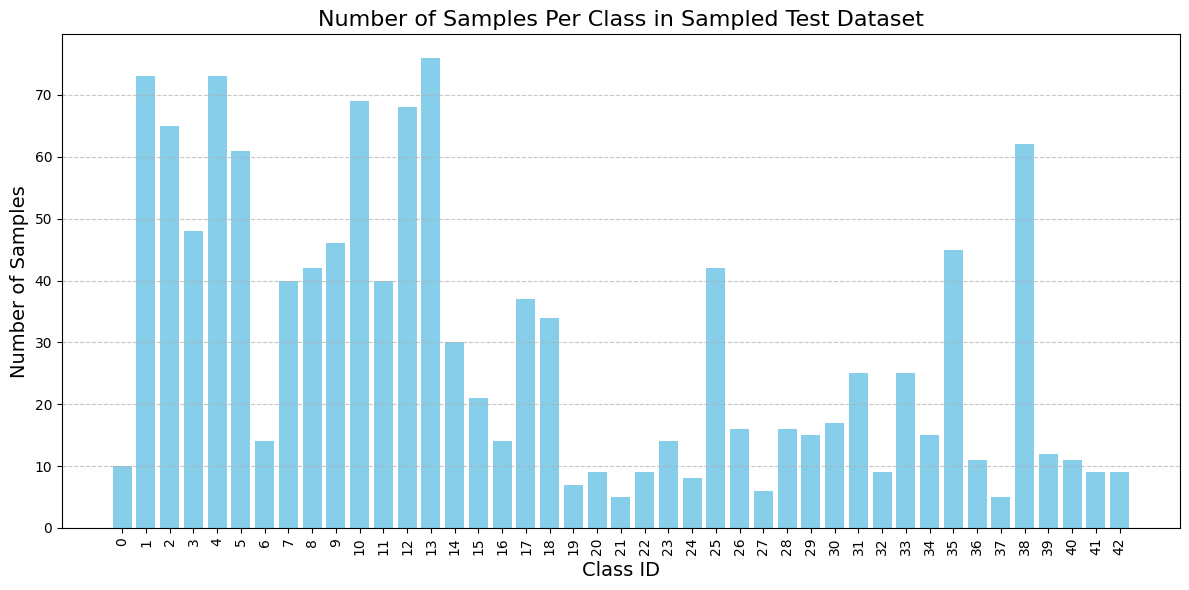

In [284]:
class_counts = df3_sampled['ClassId'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Class ID', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Number of Samples Per Class in Sampled Test Dataset', fontsize=16)
plt.xticks(class_counts.index, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [285]:
# test_data = []

# test_images = img_preprocess(df3_sampled, GOOGLE_DRIVE_PATH)

# for i, row in tqdm(df3_sampled.iterrows(), total=len(df3_sampled), desc="Processing test data", unit="row"):
#     img = test_images[i]

#     boxes = np.array([[row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']]], dtype=np.float32)
#     label = row['ClassId']

#     test_data.append({
#         "image": img,
#         "boxes": boxes,
#         "label": label
#     })

file_path3 = os.path.join(GOOGLE_DRIVE_PATH, "test_data.pkl")
with open(file_path3, "rb") as f:
    test_data = pickle.load(f)

In [286]:
# import pickle

# file_path1 = os.path.join(GOOGLE_DRIVE_PATH, "meta_data.pkl")
# with open(file_path1, "wb") as f:
#     pickle.dump(meta_data, f)
# print(f"meta_data has been saved to {file_path1}")

# file_path2 = os.path.join(GOOGLE_DRIVE_PATH, "train_data.pkl")
# with open(file_path2, "wb") as f:
#     pickle.dump(train_data, f)
# print(f"train_data has been saved to {file_path2}")

# file_path3 = os.path.join(GOOGLE_DRIVE_PATH, "test_data.pkl")
# with open(file_path3, "wb") as f:
#     pickle.dump(test_data, f)
# print(f"test_data has been saved to {file_path3}")

## Overview

In [287]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

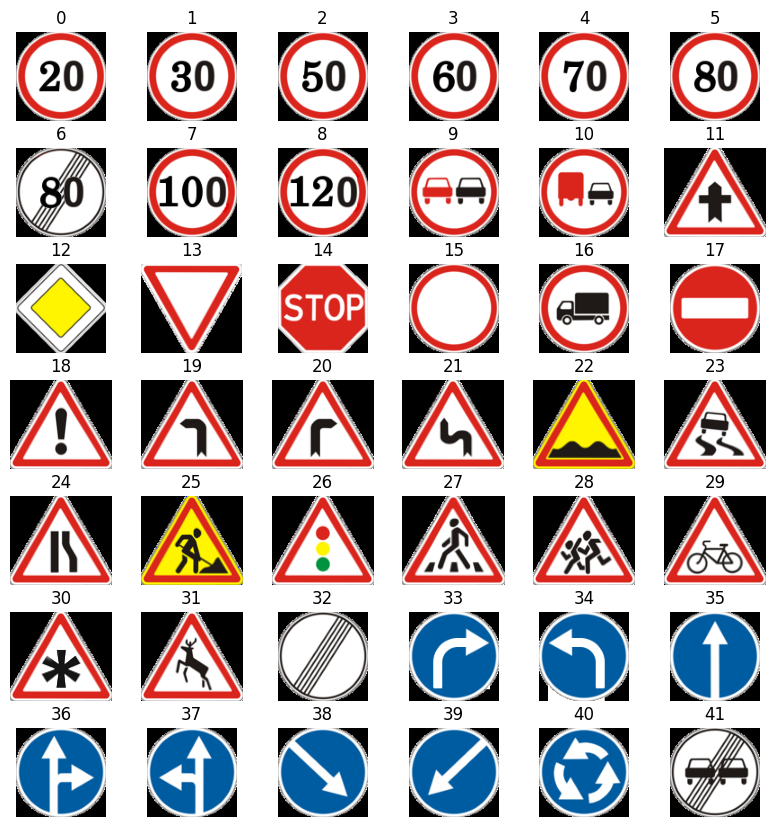

In [288]:
plt.figure(figsize=(8, 10))
for i in range(42):
    img_path = GOOGLE_DRIVE_PATH + '/Meta/' + str(i) + '.png'
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(7, 6, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)

plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

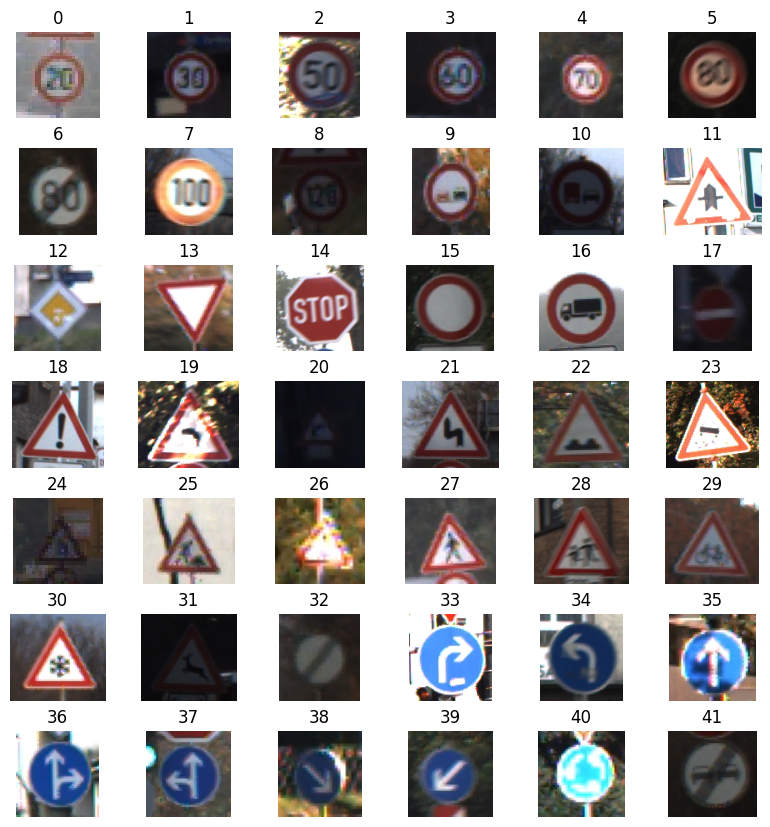

In [289]:
plt.figure(figsize=(8, 10))
for i in range(42):
    img_dir = os.path.join(GOOGLE_DRIVE_PATH, 'Train', str(i))
    img_files = os.listdir(img_dir)
    img_path = os.path.join(img_dir, img_files[0])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(7, 6, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)

plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

# Train

In [290]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim

from torchvision import models
import torch.nn as nn

In [291]:
class TrafficSignDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Access the data item
        item = self.data[idx]

        # Extract the image and ensure it's normalized and properly scaled
        image = (torch.tensor(item['image'], dtype=torch.float32).permute(2, 0, 1) / 255.0)
        image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        # Extract the label
        label = torch.tensor(item['label'], dtype=torch.long)

        return image, label

In [292]:
# Dataset Class
train_dataset = TrafficSignDataset(train_data)

# Split into train and validation sets (e.g., 80% train, 20% val)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Ensure reproducibility with a random seed
torch.manual_seed(42)
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Data Loaders with higher batch size and workers
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")

Training samples: 3136
Validation samples: 784


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [293]:
num_classes = 43

# ResNet
# Load ResNet18 with pretrained weights
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
# Replace the fully connected layer with Dropout + Linear
model.fc = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(in_features, num_classes)
)

# # MobileNetV2
# model = models.mobilenet_v2(pretrained=True)
# in_features = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(in_features, num_classes)

# # EfficientNet
# model = models.efficientnet_b0(pretrained=True)
# in_features = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [294]:
def train_one_epoch(model, optimizer, data_loader, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in data_loader:
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (optional)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        # Calculate total loss
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Return average loss and accuracy
    avg_loss = total_loss / float(len(data_loader))
    accuracy = correct / total
    return avg_loss, accuracy

In [295]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate total loss
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Handle empty dataloader gracefully
    if len(data_loader) == 0:
        return None, None

    # Compute average loss and accuracy
    avg_loss = total_loss / float(len(data_loader))
    accuracy = correct / total
    return avg_loss, accuracy

In [296]:
# Optimizer: SGD with momentum
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005
)

# Learning Rate Scheduler: ReduceLROnPlateau (adaptive learning rate adjustment)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

# Define the loss function (consider class weights if dataset is imbalanced)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [297]:
num_epochs = 30
best_val_acc = 0.0  # Initialize best validation accuracy

for epoch in range(num_epochs):
    # Training Phase
    train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, criterion, device)

    # Validation Phase
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Step the learning rate scheduler
    if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        lr_scheduler.step(val_loss)
    else:
        lr_scheduler.step()

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved Best Model with Validation Accuracy: {best_val_acc*100:.2f}%")

    # Log metrics and learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")
    print(f"Current Learning Rate: {current_lr}")

    # Optional: Early stopping (add patience parameter)
    # if no improvement in `patience` epochs, break the loop

Saved Best Model with Validation Accuracy: 4.21%
Epoch 1/30
Train Loss: 4.9247, Train Accuracy: 11.83%
Val Loss: 5.7335, Val Accuracy: 4.21%
Current Learning Rate: 0.01
Saved Best Model with Validation Accuracy: 10.84%
Epoch 2/30
Train Loss: 5.1626, Train Accuracy: 7.14%
Val Loss: 4.4671, Val Accuracy: 10.84%
Current Learning Rate: 0.01
Saved Best Model with Validation Accuracy: 17.47%
Epoch 3/30
Train Loss: 4.7188, Train Accuracy: 10.04%
Val Loss: 12.3685, Val Accuracy: 17.47%
Current Learning Rate: 0.01
Epoch 4/30
Train Loss: 4.2752, Train Accuracy: 13.65%
Val Loss: 32.0025, Val Accuracy: 9.95%
Current Learning Rate: 0.01
Saved Best Model with Validation Accuracy: 18.62%
Epoch 5/30
Train Loss: 3.7035, Train Accuracy: 16.17%
Val Loss: 2.8945, Val Accuracy: 18.62%
Current Learning Rate: 0.01
Saved Best Model with Validation Accuracy: 28.44%
Epoch 6/30
Train Loss: 3.2655, Train Accuracy: 20.38%
Val Loss: 2.4381, Val Accuracy: 28.44%
Current Learning Rate: 0.01
Saved Best Model with Vali

In [298]:
torch.save(model.state_dict(), 'faster_rcnn_traffic_signs.pth')

# Test

In [299]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.ops import box_iou
import time

In [300]:
test_dataset = TrafficSignDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
print(f"Test samples: {len(test_dataset)}")

Test samples: 1263


Note: test data errored after a load, so I use validation data to do final evaluation

In [301]:
def evaluate_model(model, data_loader, device, model_path=None):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_images = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Inference
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Calculate accuracy
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # FPS Calculation
            total_images += images.size(0)

    # Finalize FPS Calculation
    total_time = time.time() - start_time
    fps = total_images / total_time

    # Classification Accuracy
    classification_accuracy = total_correct / total_samples if total_samples > 0 else 0

    # Model Size (Optional)
    model_size = None
    if model_path:
        torch.save(model.state_dict(), model_path)
        model_size = os.path.getsize(model_path) / (1024 * 1024)

    return {
        "classification_accuracy": classification_accuracy * 100,
        "fps": fps,
        "model_size_mb": model_size
    }

In [302]:
# Evaluate the model
metrics = evaluate_model(model, val_loader, device, "faster_rcnn_traffic_signs.pth")

# Print the results
print(f"Classification Accuracy: {metrics['classification_accuracy']:.2f}%")
print(f"Frames Per Second (FPS): {metrics['fps']:.2f}")
print(f"Model Size: {metrics['model_size_mb']:.2f} MB")

Classification Accuracy: 97.70%
Frames Per Second (FPS): 1404.22
Model Size: 42.80 MB
